In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.manifold as skmanifold
import sklearn

In [9]:
# Load the datasets and print headers
catalog512 = np.load('../data/physCatalog512.npy')
catalog1024 = np.load('../data/physCatalog1024.npy')
catalog2048 = np.load('../data/physCatalog2048.npy')

In [10]:
# Convert to dataframes with mass, volume, radial distance, and magnitude of velocity

# ==============================================================================
def converter(catalog):
    # Copy data to the dataFrame
    outputDF = pd.DataFrame()
    
    outputDF['ID']         = catalog['ID']
    outputDF['volume']     = catalog['volume']
    outputDF['mass']       = catalog['mass']
    outputDF['logMass']    = np.log10(catalog['mass'])
    outputDF['rPosition']  = np.sqrt(catalog['positionX']**2 
                                     + catalog['positionY']**2 
                                     + catalog['positionZ']**2)
    outputDF['logRPosition'] = np.log10(outputDF['rPosition'])
    outputDF['zPosition']  = catalog['positionZ'].reshape(-1, 1)
    outputDF['vMag']       = np.sqrt(catalog['velocityX']**2 
                                     + catalog['velocityY']**2 
                                     + catalog['velocityZ']**2)
    outputDF['polarAngle'] = np.arccos(np.abs(outputDF['zPosition'])/outputDF['rPosition'])
    outputDF['resolution'] = catalog['resolution']
    outputDF['time']       = catalog['time']

    return outputDF
# ==============================================================================

processed512  = converter(catalog512)
processed1024 = converter(catalog1024)
processed2048 = converter(catalog2048)

In [13]:
# ==============================================================================
def chooseSubset(catalog, lowLim):
    # Cut out the low mass clouds that are poorly sampled
    catalog = catalog[catalog['logMass'] > lowLim]

    # Cut the data set down to a reasonable number of entries for testing
    maxNumRows = 20000

    if maxNumRows > catalog.shape[0]:
        maxNumRows = catalog.shape[0]
    print(f'{maxNumRows = }')

    return catalog.sample(n=maxNumRows, replace=False)
# ==============================================================================

# Set low logMass limits for clouds
lowLim512  = 8.  # Still tbd
lowLim1024 = 4.  # Still tbd
lowLim2048 = 1.

# Now call the function with the chosen catalog
catalogSubset = chooseSubset(processed1024, lowLim1024)

maxNumRows = 1696


In [14]:
# Run t-SNE
# perplexity should be between 5 and 50, analogous to number of neareset neighbors
perp = 100

featureColumns = ['logRPosition','vMag', 'polarAngle', 'logMass', 'time']
catalogSubsetData = catalogSubset[featureColumns].values

# Rescale data
scaler = sklearn.preprocessing.StandardScaler(with_mean=True, with_std=True)
catalogSubsetData = scaler.fit_transform(catalogSubsetData)

tsneModel   = skmanifold.TSNE(n_components=2, perplexity=perp, init='pca')
tsneResults = tsneModel.fit_transform(catalogSubsetData)

In [15]:
# Add the new columns to catalogSubset
catalogSubset['tsne-0'] = tsneResults[:,0]
catalogSubset['tsne-1'] = tsneResults[:,1]

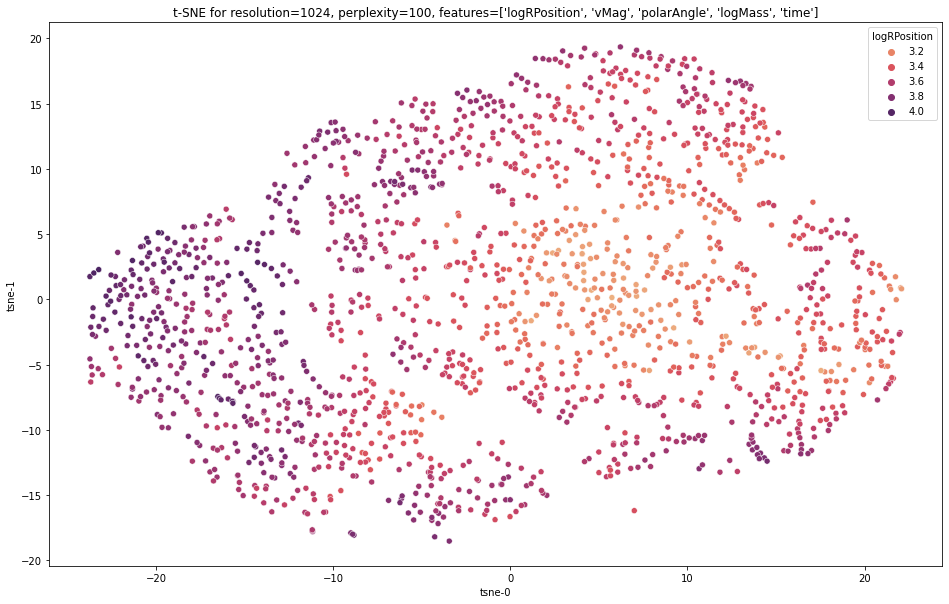

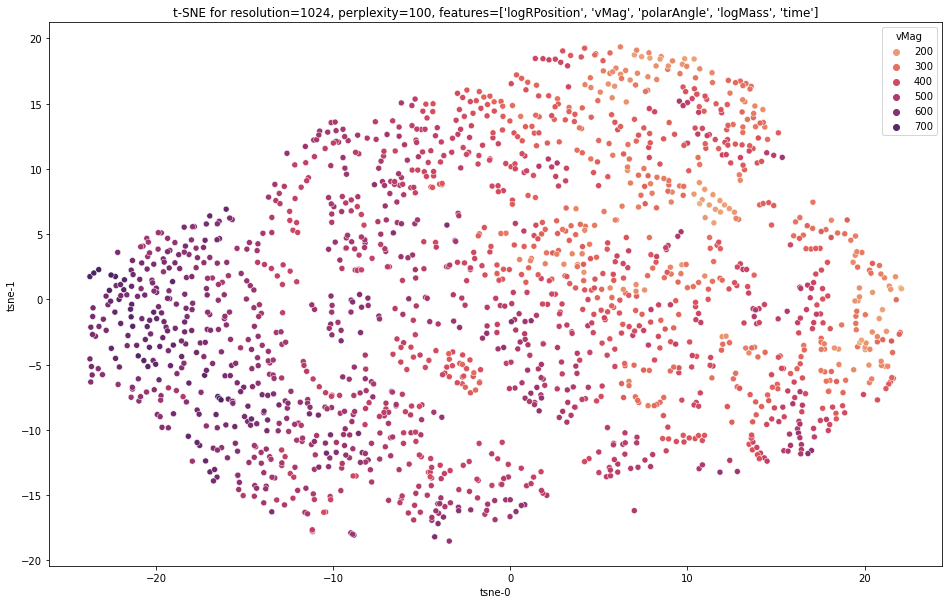

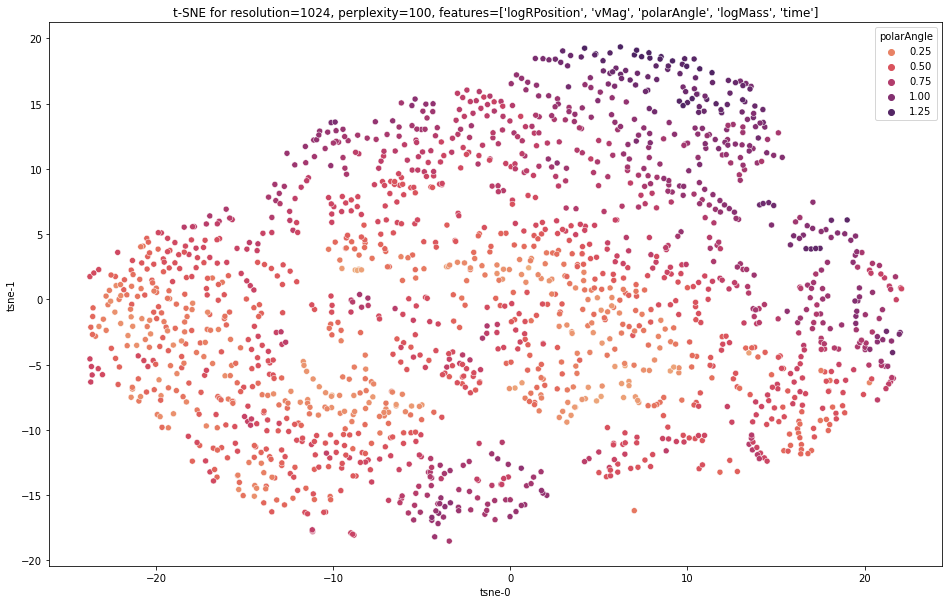

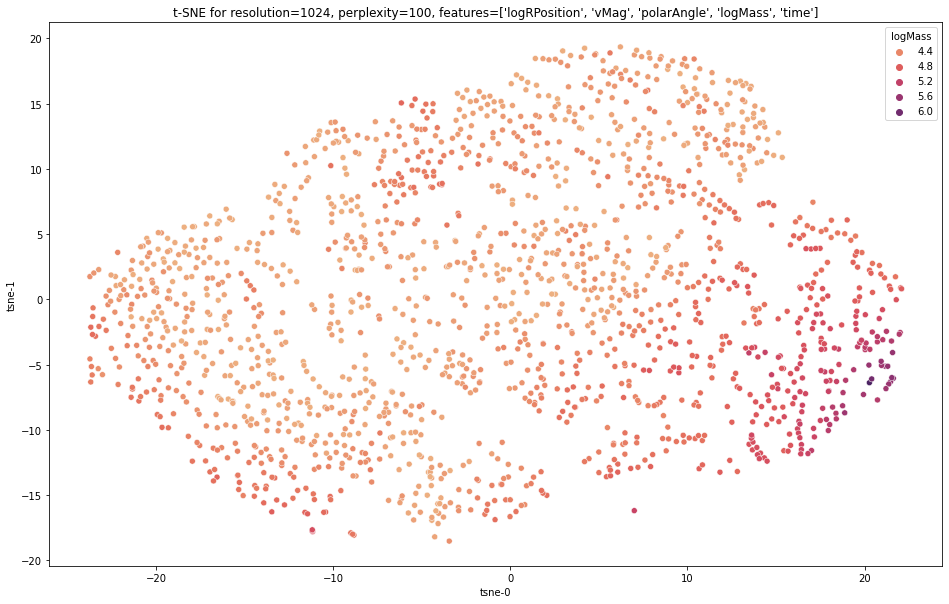

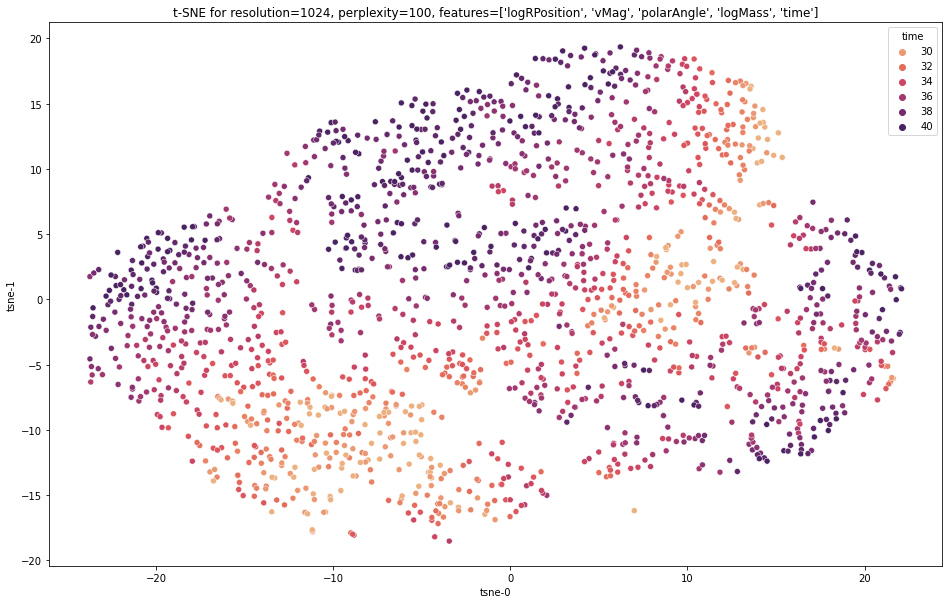

In [16]:
resolution = catalogSubset['resolution'].iloc[1]

# pathRoot = '/Users/Bob/Desktop/ASTR-3705-Class-Project/figures/tSNE/'
pathRoot = '/Users/Bob/Desktop/'
figureFormat = '.pdf'

for feat in featureColumns:
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x='tsne-0', 
        y='tsne-1',
        hue=feat,
        palette='flare',
        data=catalogSubset,
        alpha=1.
    )

    plt.title(f't-SNE for resolution={resolution}, perplexity={perp}, features={[feat for feat in featureColumns]}')

    filename = f'r{resolution}-p{perp}-{feat}'
    plt.savefig(pathRoot + filename + figureFormat)

    plt.show()